# Swiss-Roll Generation with DDPM

- 기수: 14

- 이름: 신태희

- 작성자: 13기 강승우

*본 과제 문제는 Stanford CS231n의 Assignment와 KAIST KAIST Visual AI Group의 Assignment를 참고하여 작성되었음을 밝힙니다.*

**먼저 구글드라이브-내드라이브 폴더 내에 GM 폴더를 업로드해주세요**



*   내 드라이브

    *   GM


**구글 드라이브에 연결이 뜨면 체크박스를 모두 체크하고 계속**

In [4]:
# 코랩에 드라이브의 폴더를 마운트
from google.colab import drive
drive.mount('/content/drive')

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/GM')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Visualize target and prior distributions

**아래 코드 실행 후 발생하는 오류 해결 방법**

> 오류가 발생하는 것이 정상이고, 그렇지 않다면 그냥 넘어가셔도 됩니다.

> 런타임이 끊겼다 재실행되면 다시 기본 세팅으로 돌아올 수 있으니 매번 다시 수정하셔야합니다.


1.   에러 출력창의 `/usr/local/lib/python3.12/dist-packages/IPython/extensions/autoreload.py`를 클릭
2.   우측에 라이브러리 내부 코드 창이 열리는 것을 확인 -> 4
3.   창이 열리지 않는다면, 우선 좌측 열쇠아이콘 아래 폴더아이콘을 누르고, 파일 창에서 "(폴더그림).."을 눌러 usr폴더가 있는 상위 디렉토리로 이동. 이후 경로 `/usr/local/lib/python3.12/dist-packages/IPython/extensions/autoreload.py` 를 따라 직접 파일을 찾아 autoreload.py 클릭
4. 우측에 내부 코드 창이 열리면, 코드 121번째 줄(2번의 경우 바로 이동 됨)을 찾아 `from imp import reload`를 `from importlib import reload`로 수정. **(imp->importlib)**
5.  우측 창에서 `ctrl + s` 를 눌러 저장하고, 창 상단의 autoreload.py 탭 이름 좌측에 있던 *모양이 사라지는지 확인
6.  코드 재실행

In [5]:
%load_ext autoreload
%autoreload 2

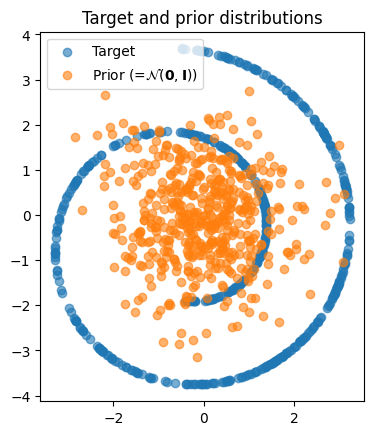

In [6]:
from dataset import TwoDimDataClass, get_data_iterator
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Output
from IPython.display import display, clear_output
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import io

target_ds = TwoDimDataClass(dataset_type='swiss_roll',
                            N=1000000,
                            batch_size=256)

prior_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                           N=1000000,
                           batch_size=256)

num_vis_particles = 500
sample_f = target_ds[0:num_vis_particles]
sample_b = prior_ds[0:num_vis_particles]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample_f[:, 0], sample_f[:, 1], alpha=0.6)
ax.scatter(sample_b[:, 0], sample_b[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and prior distributions"
ax.set_title(strtitle)
ax.legend(['Target', r'Prior (=$\mathcal{N}(\mathbf{0}, \mathbf{I})$)'])

# Define a diffusion model

먼저 `network.py`에 노이즈 예측 네트워크 `SimpleNet`을 구현해야 합니다.

이 네트워크는 TimeLinear 레이어들로 구성되며, 각 레이어의 입력과 출력 차원은 `[dim_in, dim_hids[0], ..., dim_hids[-1], dim_out]` 순서가 되어야 합니다.

마지막 TimeLinear 레이어를 제외한 모든 TimeLinear 레이어 뒤에는 ReLU 활성화 함수가 따라와야 합니다.

In [7]:
from network import SimpleNet
from ddpm import BaseScheduler, DiffusionModule

# hyperparameters #
# Don't change it
device = "cuda" if torch.cuda.is_available() else "cpu"
config = {
    "num_diffusion_steps": 1000,
    "dim_hids": [128, 128, 128],
    "lr": 1e-3,
    "batch_size": 128,
    "num_train_iters": 5000,
    "device": device,
}

###################

def build_ddpm(config):
    network = SimpleNet(dim_in=2,
                        dim_out=2,
                        dim_hids=config["dim_hids"],
                        num_timesteps=config["num_diffusion_steps"]
                       )
    print(network)
    var_scheduler = BaseScheduler(config["num_diffusion_steps"])

    ddpm = DiffusionModule(network, var_scheduler).to(config["device"])
    return ddpm

ddpm = build_ddpm(config)

SimpleNet(
  (net): Sequential(
    (0): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=128, bias=True)
          (1): SiLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
        )
      )
      (fc): Linear(in_features=2, out_features=128, bias=True)
    )
    (1): ReLU()
    (2): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=128, bias=True)
          (1): SiLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
        )
      )
      (fc): Linear(in_features=128, out_features=128, bias=True)
    )
    (3): ReLU()
    (4): TimeLinear(
      (time_embedding): TimeEmbedding(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=128, bias=True)
          (1): SiLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
        )
      )
      (

# Visualize q(x_t)

이제 `ddpm.py`에서 **DDPM의 전방(forward) 및 역방향(reverse) 과정**을 구현해야 합니다.

`q_sample()` 함수를 구현하세요.
`q_sample()` 함수는 $x_0$을 $x_t$로 매핑하는 전방 확산 과정입니다.


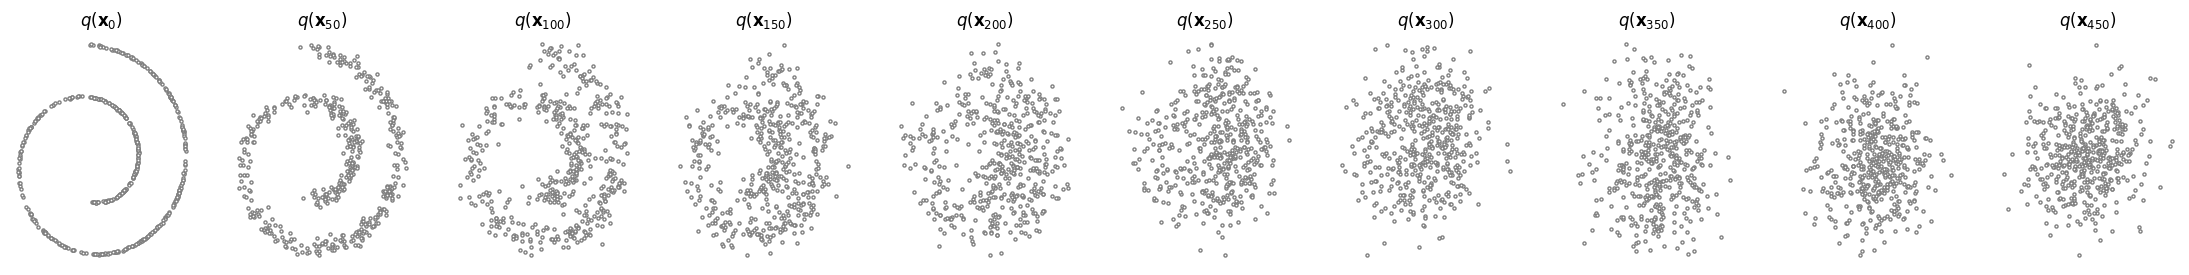

In [8]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i, t in enumerate(range(0, 500, 50)):
    x_t = ddpm.q_sample(target_ds[:num_vis_particles].to(device), (torch.ones(num_vis_particles) * t).to(device))
    x_t = x_t.cpu()
    axs[i].scatter(x_t[:,0], x_t[:,1], color='white',edgecolor='gray', s=5)
    axs[i].set_axis_off()
    axs[i].set_title(r'$q(\mathbf{x}_{'+str(t)+'})$')

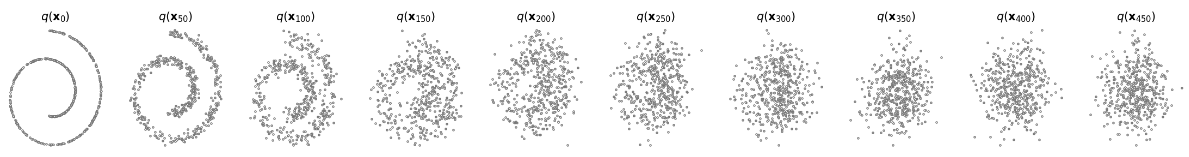

In [9]:
# You should be able to see the distributions as below.
vis_qs = Image.open("/content/drive/My Drive/GM/qs.png")
display(vis_qs)

# Training

마지막으로 `p_samle(), p_sample_loop(), compute_loss()` 함수를 구현하세요


`p_sample()` 함수는 한 스텝 역전이 과정으로 $x_t \rightarrow x_{t-1}$를 수행합니다.  

`p_sample_loop()`는 전체 역과정을 반복하여 DDPM 샘플링 알고리즘을 완성합니다.

`compute_loss()` 함수는 DDPM 논문에 나온 **단순화된 노이즈 매칭 손실**을 반환해야 합니다.  

- 학습 목표:
  $$
L_{\text{simple}}
= \mathbb{E}_{t,x_0,\epsilon}\big[\;\|\epsilon-\epsilon_\theta(x_t,t)\|^2\;\big],\qquad
x_t=\sqrt{\bar\alpha_t}\,x_0+\sqrt{1-\bar\alpha_t}\,\epsilon,\;\epsilon\sim\mathcal N(0,I).
$$

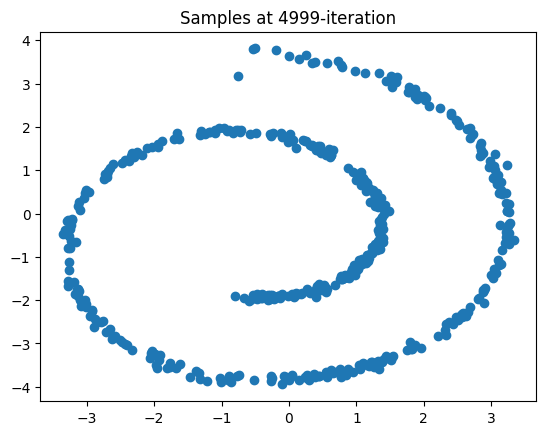

loss: 0.3005: 100%|██████████| 5000/5000 [00:40<00:00, 123.68it/s]


interactive(children=(IntSlider(value=1, description='index', max=1), Output()), _dom_classes=('widget-interac…

Output()

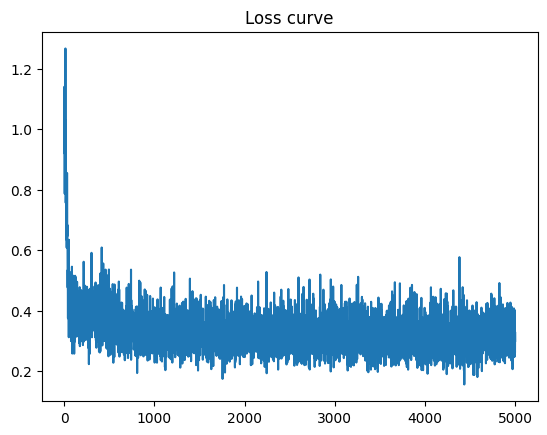

In [10]:
def figure2image(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

# Initialize the model.
ddpm = build_ddpm(config)

pbar = tqdm(range(config["num_train_iters"]))
optimizer = torch.optim.Adam(ddpm.parameters(), lr=config["lr"])
train_dl = torch.utils.data.DataLoader(target_ds, batch_size=config["batch_size"])
train_iter = get_data_iterator(train_dl)

losses = []
images = []
try:
    for step in pbar:
        optimizer.zero_grad()

        batch_x = next(train_iter)
        batch_x = batch_x.to(device)
        loss = ddpm.compute_loss(batch_x)

        loss.backward()
        optimizer.step()
        pbar.set_description(f"loss: {loss.item():.4f}")

        losses.append(loss.item())

        if step % 4999 == 0:
            with torch.no_grad():
                ####
                # NOTE: If you haven't implemented the `ddim_p_sample_loop` method,
                # use the `p_sample_loop` method instead.
                x0 = ddpm.p_sample_loop(shape=(num_vis_particles, 2)).cpu()
                # x0 = ddpm.ddim_p_sample_loop(shape=(num_vis_particles, 2)).cpu()
                ####
                fig, ax = plt.subplots(1,1)
                ax.scatter(x0[:,0], x0[:,1])
                ax.set_title(f"Samples at {step}-iteration")
                clear_output(wait=True)
                plt.show()
                img = figure2image(fig)
                images.append(img)

except KeyboardInterrupt:
    pass
finally:
    if len(images) > 0:
        slider = IntSlider(min=0, max=len(images)-1, step=1, value=1)
        output = Output()
        def display_image(index):
            with output:
                output.clear_output(wait=True)
                display(images[index])
        interact(display_image, index=slider)
        display(output)
        plt.plot(losses)
        plt.title("Loss curve")

# Evaluation

## DDPM sampling (Assignment 1)

/content/drive/MyDrive/GM/chamferdist.py:7: SyntaxWarning: invalid escape sequence '\s'
  d_CD(S1, S2) = \sigma_{x \in S1} min_{y in S2} ||x - y||^2 + \sigma_{y \in S2} min_{x in S1} ||x - y||^2


DDPM Chamfer Distance: 15.7959


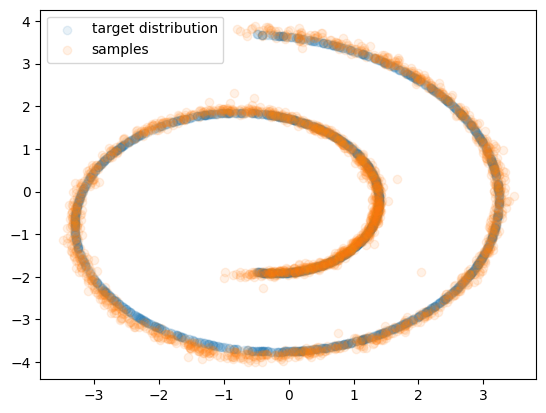

In [11]:
# You will get full credits if your chamfer distance is lower than 20.
from chamferdist import chamfer_distance

num_eval_particles = 2048
pc_ref = target_ds[:num_eval_particles]
pc_gen = ddpm.p_sample_loop(shape=(num_eval_particles, 2))

pc_gen = pc_gen.reshape(1, num_eval_particles, 2)
pc_ref = pc_ref.reshape(1, num_eval_particles, 2)
with torch.no_grad():
    cd = chamfer_distance(
            pc_gen.reshape(-1, 2).cpu().numpy(),
            pc_ref.reshape(-1, 2).cpu().numpy(),
        )
    print(f"DDPM Chamfer Distance: {cd.item():.4f}")

# Visualize samples with the target distribution.
pc_gen = pc_gen.reshape(num_eval_particles, 2).cpu().numpy()
pc_ref = pc_ref.reshape(num_eval_particles, 2).cpu().numpy()

fig, ax = plt.subplots(1,1)
ax.scatter(pc_ref[:,0], pc_ref[:,1], alpha=0.1, label="target distribution")
ax.scatter(pc_gen[:,0], pc_gen[:,1], alpha=0.1, label="samples")
ax.legend()
plt.show()